# Capstone Project -  Detecting types of vehicles on Singapore roads with Object Detection models to aid in road maintenance planning.

## Background 
In Singapore, there are about 1 million vehicles that is on our road network of more than 9,000 lane-kilometres which constitutes up to 12% of our land and road maintenance is currently maintained by Land Transport Authority (LTA). It has been known that roads, and means of transport, make a crucial contribution to economic development and growth and bring important social benefits, which is extremely important for Singapore.

## Problem Statement
In view of the periodic maintenance regime that includes periodic road inspections and surveys that were planned by LTA, we could also leverage AI related technology to better assist LTA in their road maintenance regime. As such, I had developed a vehicle recognition model through the use of AI object detection techniques to aid in detecting and classifying the number of vehicle types traveled on Singapore roads across various time periods of the day, which could potentially supplement as an additional source of information for planning road maintenance regime.

## Approach 
Traffic images were scraped on 20 March 2021 from 0000 to 2359 hours periodic at 1 minute intervals via Data.gov.sg. With this images, annotating was done with the use of Makesense.ai, a free annotating tool that runs on web browser without the need for any installation. 100 traffic images with 50 of them belonging to the time period from between 6AM to 10AM and the other remaining 50 belonging to the time period from 6PM to 10PM were picked

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os,glob
import matplotlib.pyplot as plt

import cv2 

# EDA

## Define General functions

In [2]:
def rename_path(img_filename):
    """
    This function takes in a string representing image filename in the annotation file in csv format
    and renames it to the relative path of the current project working directory where annotated images are stored in LTAdatasets folder.
    
    Arguments:
    img_filename: string
    
    Returns: relative path of image from this working folder.
    """
    #Assume the path of the images that were annotated are in form of xxxx-2021_xx_xx_hhmmss.jpg
    
    cctv_id = img_filename.split("-")[0]
    directory_to_img = os.path.join("LTAdatasets", cctv_id, "annotate")
    relative_path = os.path.join(directory_to_img, img_filename)
    return relative_path

def consolidate_csv(df, lst_of_csv):
    """
    This functions takes in a dataframe and appends the contents of all csv in the provided
    list to the empty dataframe which is subsequently returned.
    
    Arguments:
    @df:python dataframe
    @lst_of_csv: list of csv files to be parsed 
    """
    entries = 0
    for i, csv in enumerate(lst_of_csv):
        #print(f"Processing {csv}")
        temp_df = pd.read_csv(csv, header = None)
        temp_df.columns = column_names
        
        #Apply renaming of lorry/truck
        temp_df["label_text"] = temp_df["label_text"].apply(lambda x: "lorry_truck" if x=="lorry/truck" else x)
        number_entries = temp_df.shape[0]
        entries += number_entries
        #print(f"Found number of {number_entries} annotations")
        
        #Take the path and exclude the ./ infront of string
        temp_df["rel_path"] = csv.rsplit("/", 1)[0][2:]
        df = df.append(temp_df, ignore_index = True, sort=True)
    print(f"Total {entries} entries generated")
    print("")
    return df

def convert2fullpath(rel_path):
    """
    This function accepts a relative path string and returns a absolute path
    
    Arguments:
    @rel_path: Relative path of a file
    """
    full_path = os.path.join(os.getcwd(),rel_path)
    #print(full_path)
    return full_path

def create_df_columns(df):
    type_mapping = {"car": 1, "lorry_truck": 2, "van": 3, "bike": 4, "bus": 5}
    
    # Create additional columns for TFRecords
    df["label"] = df["label_text"].map(type_mapping)
    df["x_right"] = df["x_left"] + df["x_diff"]
    df["y_btm"] = df["y_top"] + df["y_diff"]
    
    df["img_path"] = df["rel_path"] + "/"+ df["img_name"]
    #df["img_path"] = df["img_path"].apply(convert2fullpath)
    
    #Drop interim column
    df.drop(labels= "rel_path",axis = 1, inplace= True)
    df["x_center"] = 0.5 * (df["x_left"] + df["x_right"])
    df["y_center"] = 0.5 * (df["y_top"] + df["y_btm"])

    # Creating columns to store scaled data for YOLO
    df["x_center_scaled"] = df["x_center"]/df["x_pixels"]
    df["y_center_scaled"] = df["y_center"]/df["y_pixels"]
    df["width_scaled"] = df["x_diff"]/df["x_pixels"]
    df["height_scaled"] = df["y_diff"]/df["y_pixels"]
    
    
    
    return df

## Check number of annotation files

In [3]:
# Read 
list_of_csv = []
annotated_cctv_id = []
directory = r'./LTAdatasets/**'
for filename in glob.iglob(directory, recursive=True):
    if os.path.isfile(filename) and filename.endswith(".csv"): # filter directory
        # Assume filename is ./LTAdatasets/2703/annotate/labels_2703_2021-03-27-10-39-44.csv
        cctv_id = filename.split("/")[-3] 
        #print(filename)
        annotated_cctv_id.append(cctv_id)
        list_of_csv.append(filename)

In [4]:
#Check number of cctv feeds with annotations
print((len(list_of_csv)))

27


In [5]:
# Count the number of images collected
total_image_count = 0
for filename in glob.iglob(directory, recursive=True):
    if os.path.isfile(filename) and filename.endswith(".jpg"): # filter directory
        total_image_count+=1
print(f"Total images in directory: {total_image_count}")

Total images in directory: 35984


## Check amount of vehicle classifications annotated 
A breakdown of vehicle classfications in each cctv footage identified by ID is provided.

In [6]:
# Define the column names for the csv file representing the vehicle annotation
column_names = ["label_text","x_left","y_top","x_diff","y_diff","img_name","x_pixels","y_pixels"]

Execute the check on the instances for each vehicle classification

In [7]:
Images_processed = len(list_of_csv) * 100
total_annotated = 0

# Dictionary to store the numbers on the vehicle classifications that were annotated.
veh_class_dict = {
    "car" : 0,
    "lorry_truck" : 0,
    "bike" : 0,
    "van" : 0,
    "bus": 0
}


veh_class_stats = {
    "car" : [],
    "lorry_truck" : [],
    "bike" : [],
    "van" : [],
    "bus": []
}

# List to capture number of images annotated per 100 images in annotated folder. To be used for plotting spread of
# number of vehicles that actually exists per image for 100 images
number_of_images_annotated_stats = [] 

#Dictioinary to store data on image resolutions
resolution_dict = dict()

for i,csv in enumerate(list_of_csv):
    df = pd.read_csv(csv, header = None)
    df.columns = column_names
    
    #Rename lorry/truck labelling to prevent downstream issue when doing mean avg precision calculation
    df["label_text"] = df["label_text"].apply(lambda x: "lorry_truck" if x=="lorry/truck" else x)
    images_annotated = df["img_name"].nunique()
    
    # Add number of annotations to overall counter
    total_annotated += images_annotated
    
    # Append number of annotations to a tracker list 
    number_of_images_annotated_stats.append(images_annotated) 
    interim_dictionary = dict(df["label_text"].value_counts())
    print(f"Csv file {csv} contains {images_annotated} annotated images")
    print(interim_dictionary)
    
    # Tabulate the resolution of the images as a tuple
    df["resolution"] = list(df[['x_pixels', 'y_pixels']].itertuples(index=False, name=None))
    df["resolution"] = df["resolution"].astype(str)
    img_resolution_dictionary = dict(df["resolution"].value_counts())
    
    #Append the values into main vehicle classification count and stats dictionary
    for classification in interim_dictionary.keys():
        veh_class_dict[classification] += interim_dictionary[classification]
        veh_class_stats[classification].append(interim_dictionary[classification])
        #print()

    #Append the values into main vehicle classification count dictionary
    for resolution in img_resolution_dictionary.keys():
        if resolution not in resolution_dict:
            # Add entry if the resolution does not exist in the first place
            resolution_dict[resolution] = img_resolution_dictionary[resolution]
        else:
            resolution_dict[resolution] += img_resolution_dictionary[resolution]
    print(" ")
print(f"{Images_processed} processed. Out of which {total_annotated} images have annotations")

Csv file ./LTAdatasets/2703/annotate/labels_2703_2021-03-27-10-39-44.csv contains 99 annotated images
{'car': 465, 'lorry_truck': 120, 'bike': 75, 'van': 55, 'bus': 17}
 
Csv file ./LTAdatasets/1502/annotate/labels_1502_2021-03-27-12-42-02.csv contains 28 annotated images
{'car': 40, 'lorry_truck': 6, 'van': 2}
 
Csv file ./LTAdatasets/1005/annotate/labels_1005_2021-03-27-06-21-08.csv contains 95 annotated images
{'car': 304, 'lorry_truck': 31, 'van': 30, 'bike': 29, 'bus': 5}
 
Csv file ./LTAdatasets/8701/annotate/labels_8701_2021-04-11-12-12-33.csv contains 100 annotated images
{'car': 260, 'lorry_truck': 241, 'bike': 62, 'van': 55, 'bus': 23}
 
Csv file ./LTAdatasets/1505/annotate/labels_1505_2021-03-27-05-19-13.csv contains 26 annotated images
{'car': 23, 'lorry_truck': 4, 'van': 3, 'bike': 2}
 
Csv file ./LTAdatasets/3702/annotate/labels_3702_2021-03-27-07-33-51.csv contains 75 annotated images
{'car': 118, 'bike': 17, 'lorry_truck': 15, 'bus': 11, 'van': 4}
 
Csv file ./LTAdatase

### Plot the spread of annotated images used in training across all CCTV feeds 

From the boxplot below, we see that in each of the annotated folders containing 100 images across our 27 annotated CCTV feeds, majority had above 70 images containing at least 1 annotation, which means the existence of vehicles.

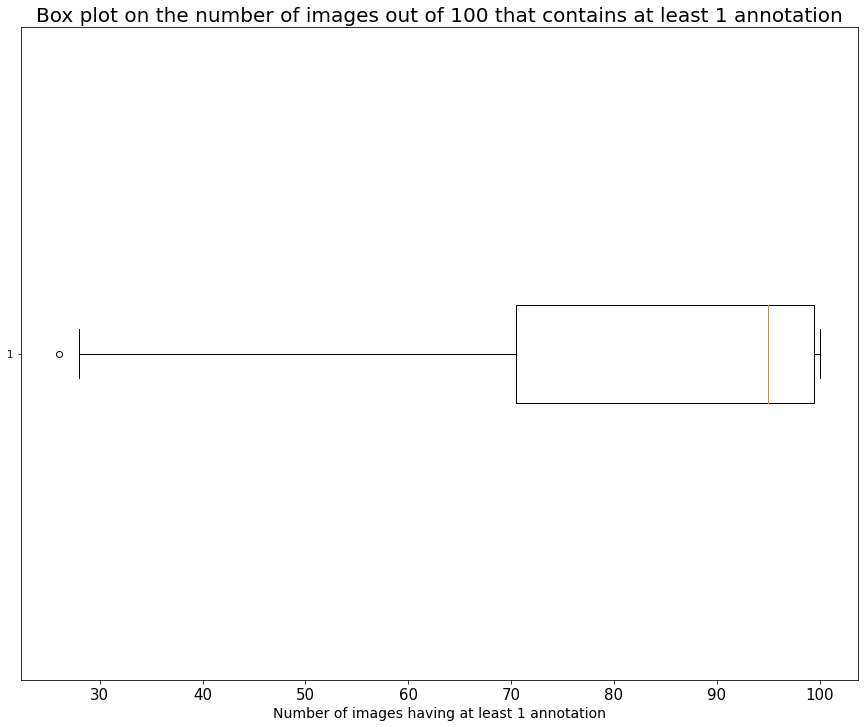

In [8]:
plt.figure(figsize = (15,12));
plt.xlabel("Number of images having at least 1 annotation", fontsize=14)
plt.xticks(fontsize = 15)
plt.title("Box plot on the number of images out of 100 that contains at least 1 annotation", fontsize=20)
plt.boxplot(number_of_images_annotated_stats, vert=False);

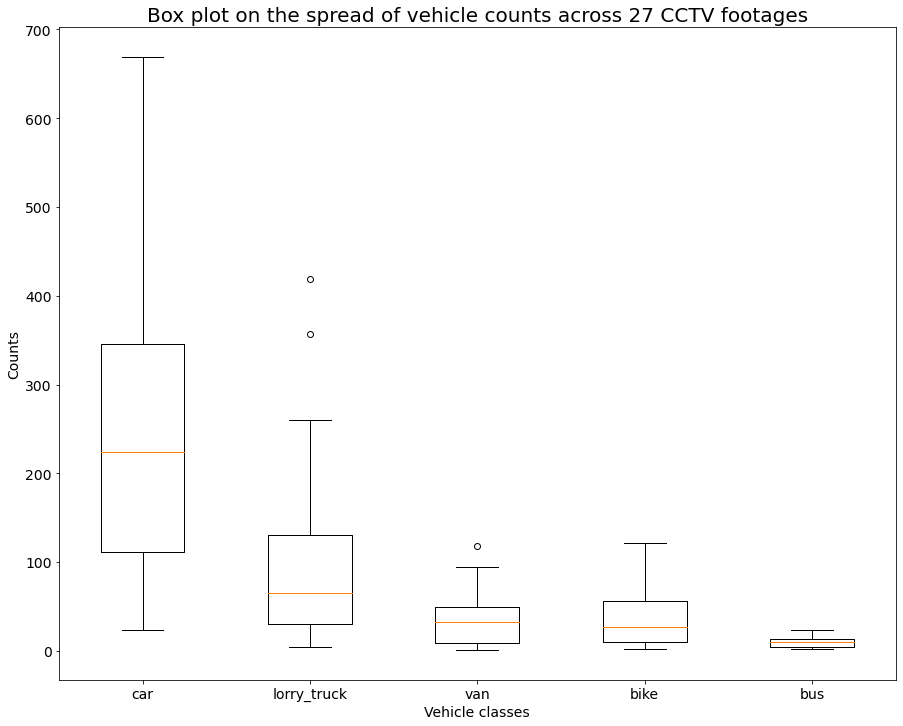

In [9]:
plt.figure(figsize = (15,12));
plt.boxplot([veh_class_stats["car"],
             veh_class_stats["lorry_truck"],
             veh_class_stats["van"],
             veh_class_stats["bike"],
             veh_class_stats["bus"]]
           );
plt.title(f"Box plot on the spread of vehicle counts across {len(list_of_csv)} CCTV footages", fontsize=20)
plt.xlabel("Vehicle classes", fontsize = 14)
plt.ylabel("Counts", fontsize = 14)
plt.xticks([1, 2, 3, 4, 5], ["car", "lorry_truck", "van", "bike", "bus"], fontsize = 14);
plt.yticks(fontsize = 14);

**Get the overall vehicle classification counts and the information of image resolution where annotations were made**

Based on the annotations that were made, we can see that there is an severe imbalance of vehicle classifications from the plot which is expected on Singapore roads, since we would always often see more cars compared to other vehicles on roads. This would have an significant effect in training a vehicle object detection model as the model trained would be bias in predicting cars the bus for example.

## Generate train validation split

Split annotated images based on their folder name

In [10]:
train_validation_split = 0.8
train_idx = int(0.8*len(list_of_csv))
train_csv_list = list_of_csv[:train_idx] 
validation_csv_list = list_of_csv[train_idx:] 

In [11]:
len(train_csv_list), len(validation_csv_list)

(21, 6)

**List the CCTV IDs which are in train and validation splits**

In [12]:
train_csv_list

['./LTAdatasets/2703/annotate/labels_2703_2021-03-27-10-39-44.csv',
 './LTAdatasets/1502/annotate/labels_1502_2021-03-27-12-42-02.csv',
 './LTAdatasets/1005/annotate/labels_1005_2021-03-27-06-21-08.csv',
 './LTAdatasets/8701/annotate/labels_8701_2021-04-11-12-12-33.csv',
 './LTAdatasets/1505/annotate/labels_1505_2021-03-27-05-19-13.csv',
 './LTAdatasets/3702/annotate/labels_3702_2021-03-27-07-33-51.csv',
 './LTAdatasets/8704/annotate/labels_8704_2021-04-11-12-42-36.csv',
 './LTAdatasets/1004/annotate/labels_1004_2021-03-27-03-36-12.csv',
 './LTAdatasets/9705/annotate/labels_9705_2021-03-27-11-23-21.csv',
 './LTAdatasets/1503/annotate/labels_1503_2021-03-27-05-02-38.csv',
 './LTAdatasets/8706/annotate/labels_8706_2021-03-29-11-29-50.csv',
 './LTAdatasets/2705/annotate/labels_2705_2021-03-29-10-21-02.csv',
 './LTAdatasets/1501/annotate/labels_1501_2021-03-27-12-33-24.csv',
 './LTAdatasets/1006/annotate/labels_1006_2021-03-27-05-44-40.csv',
 './LTAdatasets/1001/annotate/labels_1001_2021-0

In [13]:
validation_csv_list

['./LTAdatasets/2701/annotate/labels_2701_2021-03-28-12-29-57.csv',
 './LTAdatasets/3705/annotate/labels_3705_2021-03-27-07-53-19.csv',
 './LTAdatasets/1003/annotate/labels_1003_2021-03-27-02-21-06.csv',
 './LTAdatasets/9704/annotate/labels_9704_2021-03-29-11-01-54.csv',
 './LTAdatasets/1002/annotate/labels_1002_2021-03-27-04-37-49.csv',
 './LTAdatasets/2708/annotate/labels_2708_2021-03-27-11-47-35.csv']

**Populate train and validation dataframes**

In [14]:
train_df = pd.DataFrame(columns = column_names)
validation_df = pd.DataFrame(columns = column_names)

train_df = consolidate_csv(train_df, train_csv_list)
validation_df = consolidate_csv(validation_df, validation_csv_list)

Total 8597 entries generated

Total 2591 entries generated



In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_name    8597 non-null   object
 1   label_text  8597 non-null   object
 2   rel_path    8597 non-null   object
 3   x_diff      8597 non-null   object
 4   x_left      8597 non-null   object
 5   x_pixels    8597 non-null   object
 6   y_diff      8597 non-null   object
 7   y_pixels    8597 non-null   object
 8   y_top       8597 non-null   object
dtypes: object(9)
memory usage: 604.6+ KB


In [16]:
train_df.head()

,img_name,label_text,rel_path,x_diff,x_left,x_pixels,y_diff,y_pixels,y_top
0,2703-2021_03_20_074318.jpg,car,LTAdatasets/2703/annotate,35,510,640,27,360,187
1,2703-2021_03_20_074318.jpg,car,LTAdatasets/2703/annotate,19,421,640,18,360,134
2,2703-2021_03_20_074318.jpg,car,LTAdatasets/2703/annotate,17,441,640,11,360,125
3,2703-2021_03_20_074318.jpg,car,LTAdatasets/2703/annotate,20,349,640,17,360,116
4,2703-2021_03_20_074318.jpg,car,LTAdatasets/2703/annotate,36,184,640,23,360,182


In [17]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2591 entries, 0 to 2590
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_name    2591 non-null   object
 1   label_text  2591 non-null   object
 2   rel_path    2591 non-null   object
 3   x_diff      2591 non-null   object
 4   x_left      2591 non-null   object
 5   x_pixels    2591 non-null   object
 6   y_diff      2591 non-null   object
 7   y_pixels    2591 non-null   object
 8   y_top       2591 non-null   object
dtypes: object(9)
memory usage: 182.3+ KB


In [18]:
#Apply function above
train_df = create_df_columns(train_df)
validation_df = create_df_columns(validation_df)

### Save both the training and validation dataframe to csv format in current directory

In [19]:
# Define location of save path
SAVE_TRAIN_PATH = os.path.join(os.getcwd(), "train.csv")
SAVE_VALIDATION_PATH = os.path.join(os.getcwd(), "validation.csv")

train_df.to_csv(SAVE_TRAIN_PATH, index = False, header = train_df.columns)
validation_df.to_csv(SAVE_VALIDATION_PATH, index = False, header = validation_df.columns)

## Consolidate into a single dataframe for EDA
The following steps will consolidate the training and validation dataframe as single dataframe

In [20]:
#Declare a empty dataframe
combined_df = pd.concat([train_df, validation_df])
combined_df.head()

,img_name,label_text,x_diff,x_left,x_pixels,y_diff,y_pixels,y_top,label,x_right,y_btm,img_path,x_center,y_center,x_center_scaled,y_center_scaled,width_scaled,height_scaled
0,2703-2021_03_20_074318.jpg,car,35,510,640,27,360,187,1,545,214,LTAdatasets/2703/annotate/2703-2021_03_20_0743...,527.5,200.5,0.824219,0.556944,0.054688,0.075
1,2703-2021_03_20_074318.jpg,car,19,421,640,18,360,134,1,440,152,LTAdatasets/2703/annotate/2703-2021_03_20_0743...,430.5,143.0,0.672656,0.397222,0.029687,0.05
2,2703-2021_03_20_074318.jpg,car,17,441,640,11,360,125,1,458,136,LTAdatasets/2703/annotate/2703-2021_03_20_0743...,449.5,130.5,0.702344,0.3625,0.026562,0.030556
3,2703-2021_03_20_074318.jpg,car,20,349,640,17,360,116,1,369,133,LTAdatasets/2703/annotate/2703-2021_03_20_0743...,359.0,124.5,0.560937,0.345833,0.03125,0.047222
4,2703-2021_03_20_074318.jpg,car,36,184,640,23,360,182,1,220,205,LTAdatasets/2703/annotate/2703-2021_03_20_0743...,202.0,193.5,0.315625,0.5375,0.05625,0.063889


In [21]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11188 entries, 0 to 2590
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   img_name         11188 non-null  object
 1   label_text       11188 non-null  object
 2   x_diff           11188 non-null  object
 3   x_left           11188 non-null  object
 4   x_pixels         11188 non-null  object
 5   y_diff           11188 non-null  object
 6   y_pixels         11188 non-null  object
 7   y_top            11188 non-null  object
 8   label            11188 non-null  int64 
 9   x_right          11188 non-null  object
 10  y_btm            11188 non-null  object
 11  img_path         11188 non-null  object
 12  x_center         11188 non-null  object
 13  y_center         11188 non-null  object
 14  x_center_scaled  11188 non-null  object
 15  y_center_scaled  11188 non-null  object
 16  width_scaled     11188 non-null  object
 17  height_scaled    11188 non-null 

In [22]:
# Rename the file and get the other corner points of bounding box
combined_df["bbox_area"] = combined_df["x_diff"]*combined_df["y_diff"]

## Check bounding boxes sizes
From the plot below, it suggests that we have a wide variety of various bound box sizes.

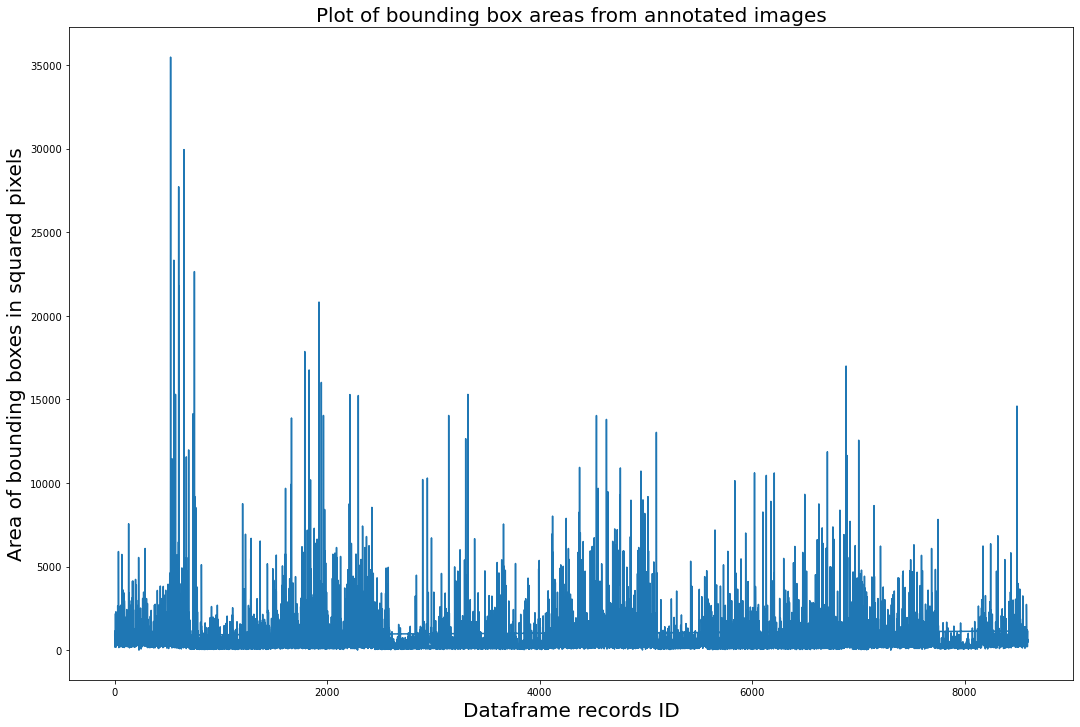

In [23]:
plt.figure(figsize = (18,12))
plt.xlabel("Dataframe records ID", fontsize=20)
plt.ylabel("Area of bounding boxes in squared pixels", fontsize=20)
plt.title("Plot of bounding box areas from annotated images", fontsize=20)
combined_df["bbox_area"].plot(kind= "line");

**Check number of vehicles annotated**

Total vehicles annotated: 11188


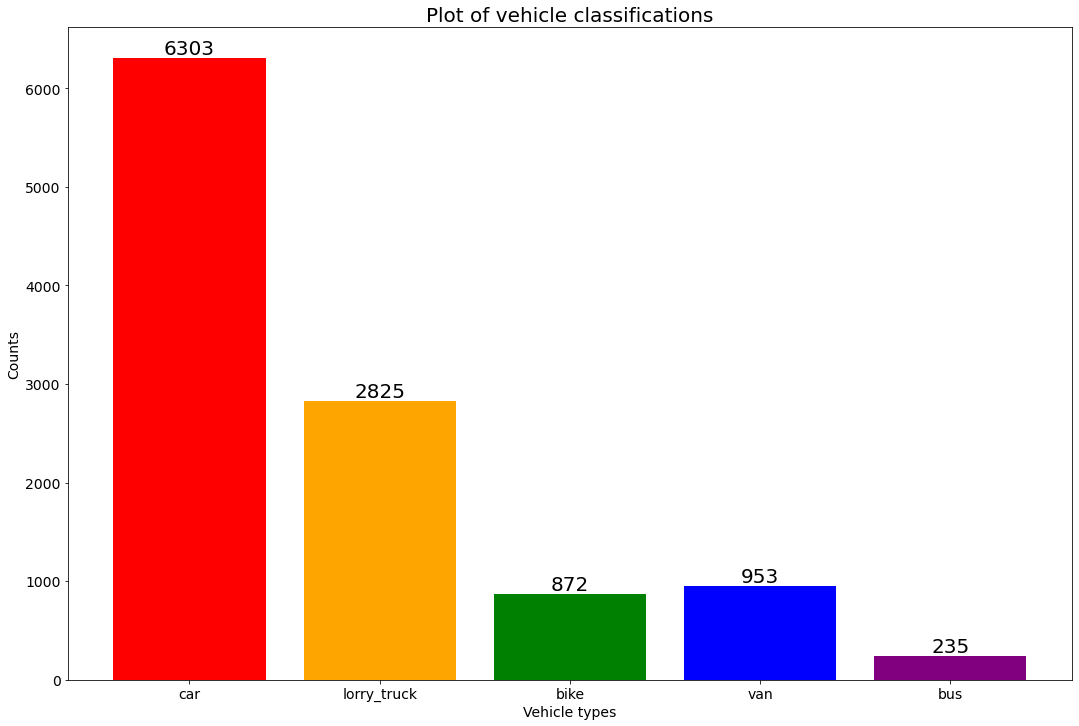

In [24]:
print(f"Total vehicles annotated: {sum(veh_class_dict.values())}")

plt.figure(figsize = (18,12))
vehicle_class = []
vehicle_count = []
for k,v in veh_class_dict.items():
    vehicle_class.append(k)
    vehicle_count.append(v)
    
bar = plt.bar(vehicle_class, vehicle_count, color = ["red", "orange", "green", "blue", "purple"])

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0,
             height,'%d' % int(height),
             ha='center',
             va='bottom',
             fontsize =20)
    
plt.title("Plot of vehicle classifications", fontsize=20)
plt.xlabel("Vehicle types", fontsize=14)
plt.xticks(fontsize = 14)
plt.ylabel("Counts", fontsize = 14)
plt.yticks(fontsize = 14)
plt.show();

## Showing an image without and with annotation

The example below provides a glance on the quality of image received as well as the vehicles that were annotated

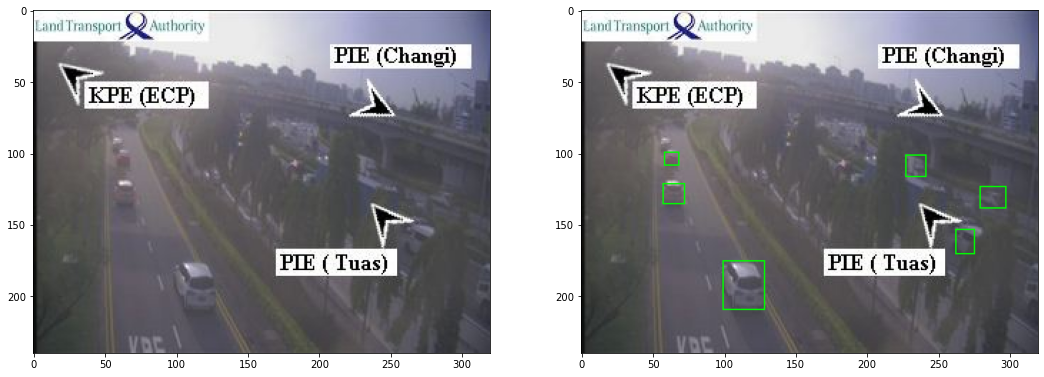

In [25]:
# Specify images to be read
image_path_example = "./LTAdatasets/1002/annotate/1002-2021_03_20_181251.jpg"
img_sample = cv2.imread(image_path_example)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

f, ax = plt.subplots(1,2, figsize = (18,18))
ax[0].imshow(img_sample)

img_name = image_path_example.split("/")[-1]
bbox_df = combined_df[combined_df["img_name"] == img_name]
#print(bbox_df.shape)

# loop through index values
for i in bbox_df.index:
    x_left = bbox_df.loc[i, "x_left"]
    y_top = bbox_df.loc[i, "y_top"]
    x_right = bbox_df.loc[i, "x_left"] + bbox_df.loc[i, "x_diff"]
    y_btm = bbox_df.loc[i, "y_top"]+ bbox_df.loc[i, "y_diff"]
    
    # draw a green rectangle to visualize the bounding rect
    cv2.rectangle(img_sample, (x_left, y_top), (x_right, y_btm), (0, 255, 0), 1)

ax[1].imshow(img_sample);

## Check distribution of image resolutions from annotations

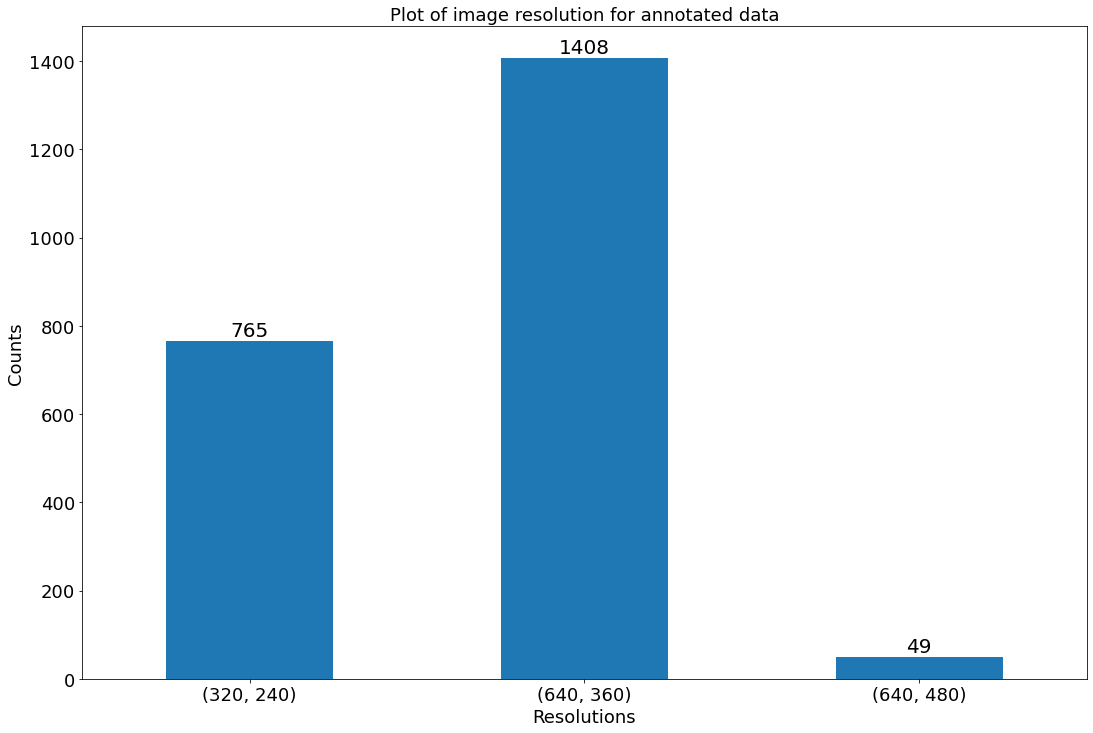

In [26]:
fig, ax = plt.subplots(figsize = (18,12))
combined_df_res = combined_df[["img_name", "x_pixels","y_pixels"]].drop_duplicates()

combined_df_res.groupby(['x_pixels', 'y_pixels']).count().plot(kind = "bar", ax = ax );


ax.set_title("Plot of image resolution for annotated data", fontsize=18)
ax.set_xlabel("Resolutions", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.tick_params(axis='x', labelsize= 18, rotation=0)
ax.tick_params(axis='y', labelsize= 18, rotation=0)

for p in ax.patches:
    ax.annotate( p.get_height(),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 10),
                   textcoords='offset points',
                   fontsize =20)
ax.get_legend().remove()

## Check the resolution of the images used for training and validation

From the plots, we see that the choice to split training and validation data resulted in uneven distribution of image resolution which may pose a problem in model training even if resizing is done. A possible way to rectify is to add in images with the corresponding underrepresented resolutions to fill the balance which is a problem given that annotations would be required in order to add them for training.

In [27]:
train_df_res = train_df[["img_name", "x_pixels","y_pixels"]].drop_duplicates()
validation_df_res = validation_df[["img_name", "x_pixels","y_pixels"]].drop_duplicates()

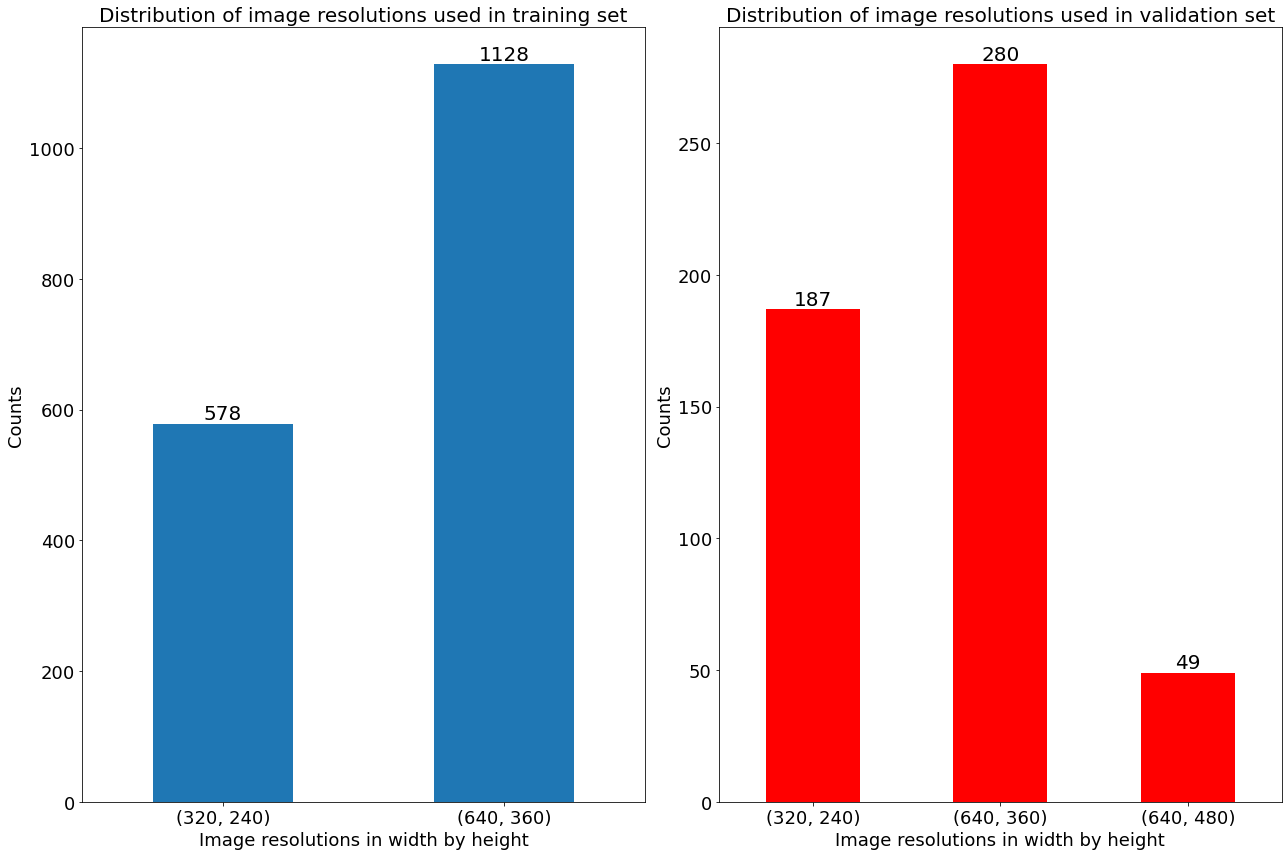

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (18,12))

train_df_res.groupby(['x_pixels', 'y_pixels']).count().plot(kind = "bar", ax = ax[0] );
validation_df_res.groupby(['x_pixels', 'y_pixels']).count().plot(kind = "bar", ax = ax[1], color = "red");

    
ax[0].set_title("Distribution of image resolutions used in training set", fontsize = 20)
ax[0].set_xlabel("Image resolutions in width by height")
ax[0].set_ylabel("Counts")

ax[1].set_title("Distribution of image resolutions used in validation set", fontsize = 20)
ax[1].set_xlabel("Image resolutions in width by height")
ax[1].set_ylabel("Counts")

ax[0].xaxis.label.set_size(18)
ax[0].yaxis.label.set_size(18)
ax[0].tick_params(axis='both', which='major', labelsize=18, rotation=0)
ax[0].tick_params(axis='both', which='minor', labelsize=18, rotation=0)

ax[1].xaxis.label.set_size(18)
ax[1].yaxis.label.set_size(18)
ax[1].tick_params(axis='both', which='major', labelsize=18, rotation=0)
ax[1].tick_params(axis='both', which='minor', labelsize=18, rotation=0)

for i in [0,1]:
    for p in ax[i].patches:
        ax[i].annotate(p.get_height(),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 10),
                       textcoords='offset points',
                       fontsize =20)
fig.tight_layout()

ax[0].get_legend().remove()
ax[1].get_legend().remove()

### Check the vehicle classification counts for training/validation data

From the training and validation data that was created, we see that the top 2 most vehicle classifications are cars and lorry_trucks. As such by fitting the data into object detection models, we are likely to predict occurence of lorry_trucks and cars better than other classes since there is no equal amount of representations per vehicle types.

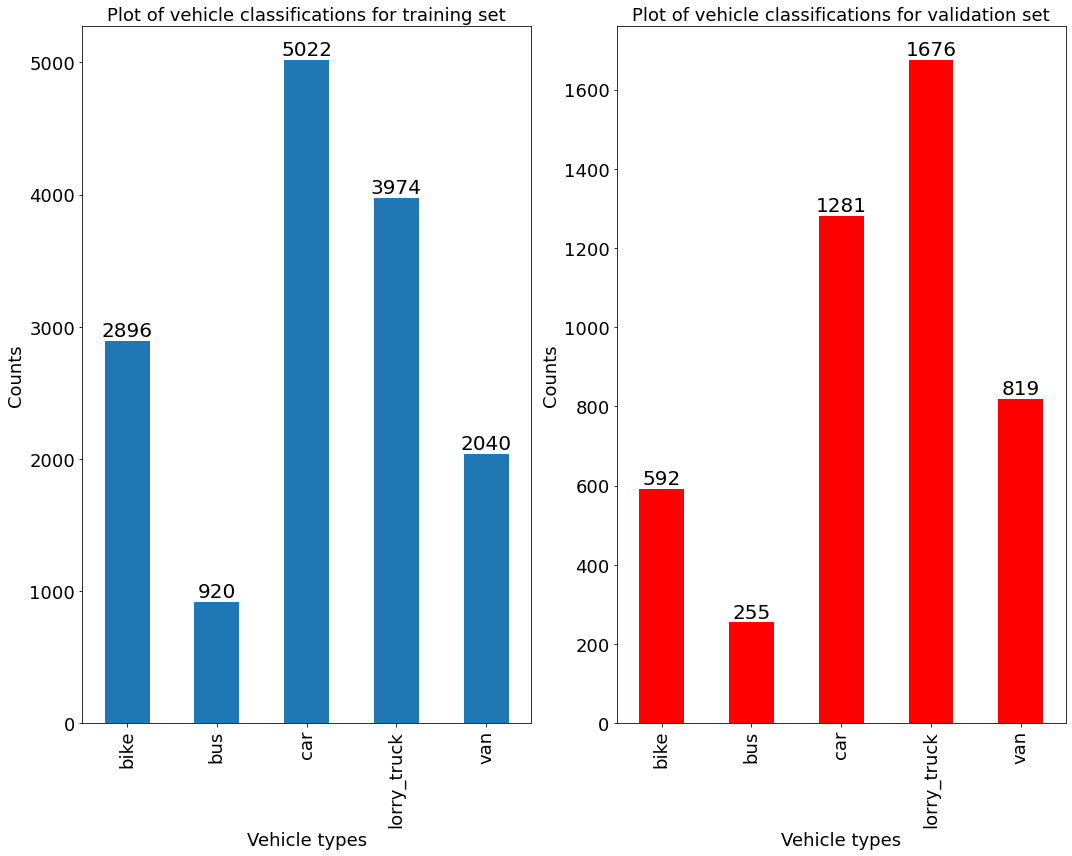

In [29]:
fig, ax = plt.subplots(1,2, figsize = (15,12))
train_df.groupby("label_text").sum().plot(kind = "bar", ax = ax[0]);
validation_df.groupby("label_text").sum().plot(kind = "bar", ax = ax[1], color = "red");
ax[0].set_title("Plot of vehicle classifications for training set", fontsize=18)
ax[0].set_xlabel("Vehicle types", fontsize=18)
ax[0].set_ylabel("Counts", fontsize=18)
ax[0].tick_params(axis='x', labelsize= 18)
ax[0].tick_params(axis='y', labelsize= 18)

ax[1].set_title("Plot of vehicle classifications for validation set", fontsize=18)
ax[1].set_xlabel("Vehicle types", fontsize=18)
ax[1].set_ylabel("Counts", fontsize=18)
ax[1].tick_params(axis='x', labelsize= 18)
ax[1].tick_params(axis='y', labelsize= 18)

for i in [0,1]:
    for p in ax[i].patches:
        ax[i].annotate( p.get_height(),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 10),
                       textcoords='offset points',
                       fontsize =20)

#Remove legend
for i in [0,1]:
    ax[i].get_legend().remove()
    
fig.tight_layout()